In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go 
import sys
# Adjust the path below to the path of your `module_directory`
sys.path.append('../thesis-2p-behavior-align/')
# Now you can import your module or function
import imaging_behavior_functions
import odor_behavioral_analysis
import scipy.cluster.hierarchy as sch
from rastermap import Rastermap, utils
from scipy.stats import zscore
from scipy.stats import sem
from scipy.spatial import KDTree
from sklearn.preprocessing import SplineTransformer
import scipy.signal

In [2]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/stacks/"
example_path_data = base_path+"20240314-4_MB042B_TOM20GCAMP7f_odor/data/"
example_path_results = base_path+"20240314-4_MB042B_TOM20GCAMP7f_odor/results/"
trial_num = 2
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, hdeltab_sequence, epg_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, hdeltab_sequence, epg_sequence)
behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

In [3]:
selected_df = neural_df.drop(columns=['time'])
selected_df

,PAM_DAN
0,0.052631
1,0.049640
2,0.040797
3,0.032467
4,0.022370
...,...
35526,0.052211
35527,0.060102
35528,0.074862
35529,0.075891


In [4]:
base_dir = '//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/stacks/20240314-4_MB042B_TOM20GCAMP7f_odor/E_05_Iter_10080/suite2p/plane0'
F = np.load(base_dir+'/F.npy', allow_pickle=True)
Fneu = np.load(base_dir+'/Fneu.npy', allow_pickle=True)
spks = np.load(base_dir+'/spks.npy', allow_pickle=True)
stat = np.load(base_dir+'/stat.npy', allow_pickle=True)
ops =  np.load(base_dir+'/ops.npy', allow_pickle=True)
ops = ops.item()
iscell = np.load(base_dir+'/iscell.npy', allow_pickle=True)

In [5]:
F_cell = F[(iscell[:,0]==1),:]
spks_cell = spks[(iscell[:,0]==1),:]
Fneu_cell = Fneu[(iscell[:,0]==1),:]
stat_cell = stat[(iscell[:,0]==1)]

### feature building

In [8]:
# heading
def circular_feature_preprocessing(x):
    # Assuming x is in radians and wraps around at 2*pi
    return np.column_stack((np.sin(x), np.cos(x)))
processed_heading = circular_feature_preprocessing(behav_df.heading)
spline = SplineTransformer(degree=2, n_knots=3)
transformed_heading = spline.fit_transform(processed_heading)
transformed_heading.shape

(35531, 8)

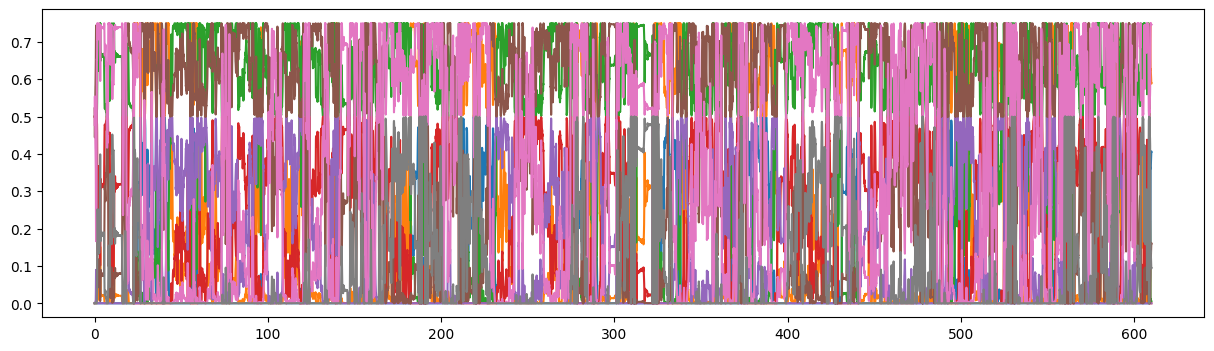

In [13]:
plt.figure(figsize=(15, 4))
for i in range(transformed_heading.shape[1]):
    plt.plot(behav_df.time, transformed_heading[:,i])

In [18]:
behav_df.head(10)

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos,cluster_label_temporal,soft_cluster_label_temporal,cluster_label_spatial
0,0.000000,0.000000,0.000000,0.000000,1.593341,0.000000,0.000000,0.000000,0,1.593341,-0.000000,0.000000,0.000000,0,0,0
1,0.017168,3.585279,-3.959612,-0.737886,1.590616,3.959612,0.737886,8.282777,1,1.590616,-0.000000,-0.003933,0.057768,0,0,0
2,0.034337,5.139794,-3.848696,-1.245503,1.584543,3.848696,1.245503,10.233994,1,1.584543,-0.000000,-0.008346,0.142305,0,0,0
3,0.051505,5.896064,-1.418253,-1.718474,1.575840,1.418253,1.718474,9.032791,1,1.575840,-0.000000,-0.011446,0.242140,0,0,0
4,0.068674,6.183029,1.866607,-2.138585,1.566291,1.866607,2.138585,10.188220,1,1.566291,-0.000000,-0.012586,0.350082,0,0,0
5,0.085842,6.124094,5.066191,-2.453844,1.558421,5.066191,2.453844,13.644129,1,1.558421,-0.000000,-0.011598,0.460155,0,0,0
6,0.103011,6.053577,7.930943,-2.659875,1.551987,7.930943,2.659875,16.644395,1,1.551987,-0.177386,-0.008652,0.571865,0,0,0
7,0.120179,6.627464,11.136893,-2.699782,1.529953,11.136893,2.699782,20.464139,1,1.529953,-0.162461,-0.005935,0.696690,0,0,0
8,0.137348,7.229388,12.458730,-2.320759,1.525922,12.458730,2.320759,22.008878,1,1.525922,-0.172651,-0.003245,0.833178,0,0,0
9,0.154516,7.333191,9.541315,-1.639527,1.519002,9.541315,1.639527,18.514033,1,1.519002,-0.175298,-0.004199,0.968478,0,0,0


In [21]:
# velocities 

# Assuming df is your DataFrame with columns 'forward', 'side', 'yaw'

def create_shifted_features(df, shifts):
    """
    Create shifted features for each column in the DataFrame.
    
    Args:
    - df (pd.DataFrame): Original DataFrame with columns to be shifted.
    - shifts (list of int): List of integers representing the shifts (positive for forward, negative for backward).
    
    Returns:
    - pd.DataFrame: DataFrame with original and shifted columns.
    """
    feature_df = df.copy()
    for col in df.columns:
        for shift in shifts:
            if shift > 0:
                feature_df[f'{col}_shifted_back_{shift}'] = df[col].shift(-shift)  # Future values
            elif shift < 0:
                feature_df[f'{col}_shifted_forward_{-shift}'] = df[col].shift(-shift)  # Past values
            # If shift == 0, do nothing (keep original column)
    feature_df = feature_df.fillna(0)
    return feature_df

# Example usage
shifts = list(range(-10,11)) # Shifts of 2 and 1 step(s) back in time, and 1 and 2 step(s) forward in time
expanded_velocity_df = create_shifted_features(behav_df[['fwV','yawV']], shifts)

#print(expanded_velocity_df.head())


In [23]:
# odors 
def find_odor_start_end(behav_df):
    odor_on = behav_df[behav_df.odor > 5].index
    odor_start = [odor_on[0]]
    odor_end = []
    for i in range(len(odor_on)-1):
        if odor_on[i+1] - odor_on[i]>5:
            odor_start.append(odor_on[i+1])
            odor_end.append(odor_on[i])
    if odor_on[-1] != len(behav_df)-1:
        odor_end.append(odor_on[-1])
    return odor_start[0:len(odor_end)], odor_end
odor_start, odor_end = find_odor_start_end(behav_df)

In [28]:
odor_start_arr = np.zeros(len(behav_df))
odor_start_arr[odor_start] = 1
behav_df['odor_on'] = odor_start_arr
odor_end_arr = np.zeros(len(behav_df))
odor_end_arr[odor_end] = 1
behav_df['odor_end'] = odor_end_arr

In [43]:
# Assuming 'df' is your DataFrame and it contains a column 'odor' for odor stimuli

def shift_and_smooth_odor(column, shifts, kernel_size):
    """
    Shift the odor column forward in time and smooth it with a kernel.
    
    Args:
    - df (pd.DataFrame): DataFrame with the 'odor' column.
    - shifts (list of int): List of shift amounts (positive for forward in time).
    - kernel_size (int): Size of the kernel for convolution (number of points).
    
    Returns:
    - pd.DataFrame: DataFrame with shifted and smoothed odor columns.
    """
    # Create a raised cosine bump kernel
    x = np.linspace(-np.pi, np.pi, kernel_size)
    kernel = np.cos(x)**2
    kernel /= kernel.sum()  # Normalize the kernel
    
    # Copy the DataFrame to avoid modifying the original
    new_df = pd.DataFrame()
    
    for shift in shifts:
        shifted_odor = column.shift(-shift).fillna(0)
        # Convolve with the kernel and assign to a new column
        smoothed_odor = scipy.signal.convolve(shifted_odor, kernel, mode='same')
        new_df[f'odor_shifted_{shift}_smoothed'] = smoothed_odor
        
    return new_df

# Example usage
shifts = [1, 2, 3, 4]  # Shifts forward in time by 1, 2, 3, 4 time points
kernel_size = 10  # Size of the convolution kernel

expanded_odor_df = shift_and_smooth_odor(behav_df.odor_on, shifts, kernel_size)

# Display the first few rows of the new DataFrame
print(expanded_odor_df.head())


   odor_shifted_1_smoothed  odor_shifted_2_smoothed  odor_shifted_3_smoothed  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   odor_shifted_4_smoothed  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
